In [6]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [8]:
#Thor DataLoad
# Specify the path to the manually downloaded dataset
data_dir = r'C:\Users\thorp\OneDrive\Dokumenter\Uni\Kandidat\Anvendt maskinlæring\Exam\Data\patch_camelyon'

# Load PatchCamelyon dataset using TFDS
dataset_name = 'patch_camelyon'
dataset, info = tfds.load(name=dataset_name, split='train', with_info=True, data_dir=data_dir)


In [ ]:
#API load
import tensorflow as tf
import tensorflow_datasets as tfds

# Load 10% of the PatchCamelyon dataset using TFDS
dataset_name = 'patch_camelyon'
percentage = 10

# Define the split using tfds.percent
split = f'train[:{percentage}%]'

# Load the dataset with the specified split
dataset, info = tfds.load(name=dataset_name, split=split, with_info=True)

# Display dataset information
print("Number of examples in 10% subset:", info.splits['train'].num_examples)


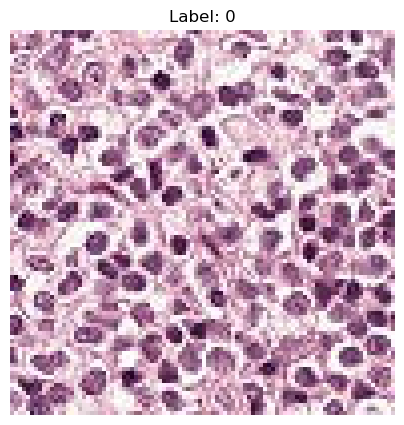

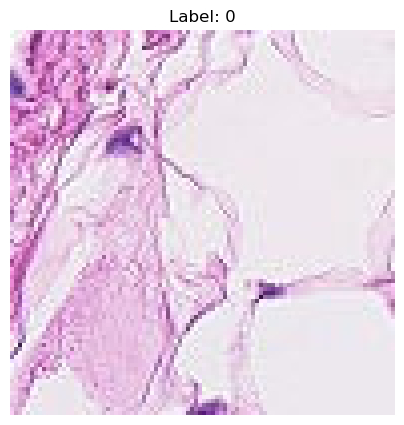

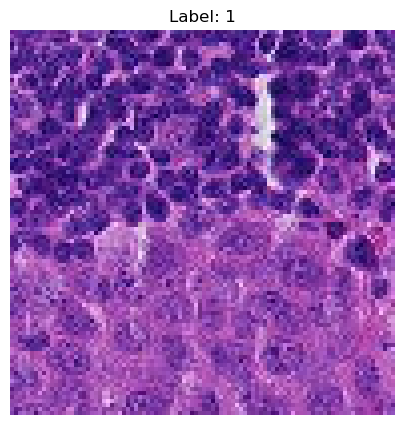

In [7]:
# Display the first three images
for i, example in enumerate(dataset.take(3)):
    image, label = example['image'], example['label']
    
    # Convert the TensorFlow tensor to a NumPy array for visualization
    image_np = image.numpy()

    # Display the image and label
    plt.figure(figsize=(5, 5))
    plt.imshow(image_np)
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')
    plt.show()

In [11]:
# Display dataset information
print("Dataset name:", info.name)
print("Number of classes:", info.features['label'].num_classes)
print("Class names:", info.features['label'].names)
print("Number of examples:", info.splits['train'].num_examples)
print("Image shape:", info.features['image'].shape)
print("Dataset description:", info.description)

Dataset name: patch_camelyon
Number of classes: 2
Class names: ['0', '1']
Number of examples: 262144
Image shape: (96, 96, 3)
Dataset description: The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.


**Problem 1:** 

During the semester you have become very excited about working on the PatchCamelyon (PCam) 
data. Like Veeling et al (2018), you are primarily interested in developing machine learning models that, based on patches of whole-slide images of lymph node sections, can assist pathologists in 
tumor detection.  

The primary objective of this exam is to perform image classification on the PCam dataset, with a 
focus on using autoencoders for image compression.  As a reminder, the PCAM dataset consists of 327,680 color images (96x96pxs) extracted from 
histopathologic scans of lymph node sections. Each image is annotated with a binary label 
indicating presence of metastatic tissue. Specifically, the dataset is divided into 262,144 training 
images, 32,768 validation images, and 32,768 test images. You must use the training/validation 
images to train/validate models that perform well at classifying the test images. Importantly, you are not required to use the full dataset. Use the amount of data that is feasible for you and your hardware configuration.

The PCam dataset is available from many online sources but 
some of them are very slow. Therefore, I recommend accessing the dataset from my SDU 
repository: Link to PCAM. Further instructions and hints on how to load the data efficiently and flexibly by using the module tfds|Tensorflow Dataset are available on the course site’s itslearning platform.

Questions:

You wish to perform image classification. However, you are a little concerned about the size of the 
PCAM images. Their size might be too demanding for your hardware configuration, potentially 
hindering proper hyperparameter tuning and downstream model evaluation. Hence, you wish as a 
pre-processing step to compress the images by using autoencoders (both AEs and VAEs).

1. Discuss how you can use autoencoders to compress images. Motivate why you think 
compressing the images by using AE/VAE will work here and will be better than just simple 
resizing for example by using the function:  

**Initial AE**

In [ ]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=(20,), activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'), # this is the bottleneck layer
], name='encoder')

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=(5,), activation='relu'), 
    # 5 since we compress features into 5 neurons
    tf.keras.layers.Dense(20), 
    # map back to 20 as we have 20 features and want to reconstruct these
], name='decoder')

autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

Why is AE or VAE preferred to 